In [ ]:
import pyarrow.parquet as pq
import json
from typing import List, Dict, Generator
from tqdm import tqdm
from datasets import Dataset
import gc

# HDFS上Parquet文件的路径
hdfs_path = "viewfs://hadoop-lt-cluster/home/mmu_llm/dw/mmu_llm.db/customjtmath_2013_20/type=normal/part-04999-626445f5-ee23-4a80-b0bd-e35648f16988.c000.snappy.parquet"

def parse_json_content(json_str: str) -> str:
    try:
        json_data = json.loads(json_str)
        return json_data.get('content', '')
    except json.JSONDecodeError:
        return ''

def read_and_parse_parquet(file_path: str, max_chunks: int = None, max_length: int = 5000) -> Generator[Dict[str, str], None, None]:
    try:
        parquet_file = pq.ParquetFile(file_path)
        print(f"文件包含 {parquet_file.num_row_groups} 个行组")
        print(f"文件模式: {parquet_file.schema}")
        
        for i in tqdm(range(min(max_chunks or float('inf'), parquet_file.num_row_groups))):
            table = parquet_file.read_row_group(i)
            df = table.to_pandas()
            if 'text' in df.columns:
                for text in df['text']:
                    content = parse_json_content(text)[:max_length]
                    if content:
                        yield content
            print(f"处理完第 {i+1} 个行组")
            if max_chunks and i + 1 >= max_chunks:
                print(f"已达到指定的最大块数 {max_chunks}，停止读取")
                break
    except Exception as e:
        print(f"读取文件时出错: {e}")

# 读取并解析数据
parsed_data = list(read_and_parse_parquet(hdfs_path, max_chunks=2))

if parsed_data:
    print(f"\n成功读取并解析数据")
    print(f"总共解析的数据条数: {len(parsed_data)}")
    print("前5条解析后的内容:")
    for item in parsed_data[:5]:
        print(item[:100] + '...')  # 只打印每条内容的前100个字符

    # 将解析后的数据转换为Hugging Face Dataset格式
    # dataset = Dataset.from_list(parsed_data)
    texts = parsed_data
    gc.collect()  # 强制进行垃圾回收

else:
    print("无法读取或解析数据")

In [ ]:
import pandas as pd
from src.text_clustering import ClusterClassifier
from cycler import cycler
import matplotlib.pyplot as plt

# Ensure you have a pandas DataFrame named pandas_df
# Example:
# pandas_df = pd.DataFrame({'content': ["text1", "text2", "text3"]})

# Create an instance of ClusterClassifier
cc = ClusterClassifier(
    embed_device="cuda",
)

# Run the pipeline on the 'content' column

embs, labels, summaries = cc.fit(texts)

# Customize color scheme (optional)
# default_cycler = (cycler(color=[
#     "#0F0A0A", "#FF6600", "#FFBE00", "#496767", "#87A19E",
#     "#FF9200", "#0F3538", "#F8E08E", "#0F2021", "#FAFAF0"
# ]))
# plt.rc('axes', prop_cycle=default_cycler)

# Visualize the results
cc.show(interactive=False)

# Save the classifier (optional)
cc.save("./content_clusters")


# If you want to classify new texts later:
# new_texts = ["Some new text", "Another new text"]
# cluster_labels, embeddings = cc.infer(new_texts, top_k=1)

/mmu_nlp_hdd/suzhou03/data/text-clustering/myenv_python3.8_text_clustering/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/mmu_nlp_hdd/suzhou03/data/text-clustering/myenv_python3.8_text_clustering/lib/python3.8/site-packages/transformers/utils/hub.py:124: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-MiniLM-L6-v2
/mmu_nlp_hdd/suzhou03/data/text-clustering/myenv_python3.8_text_clustering/lib/python3.8/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_down

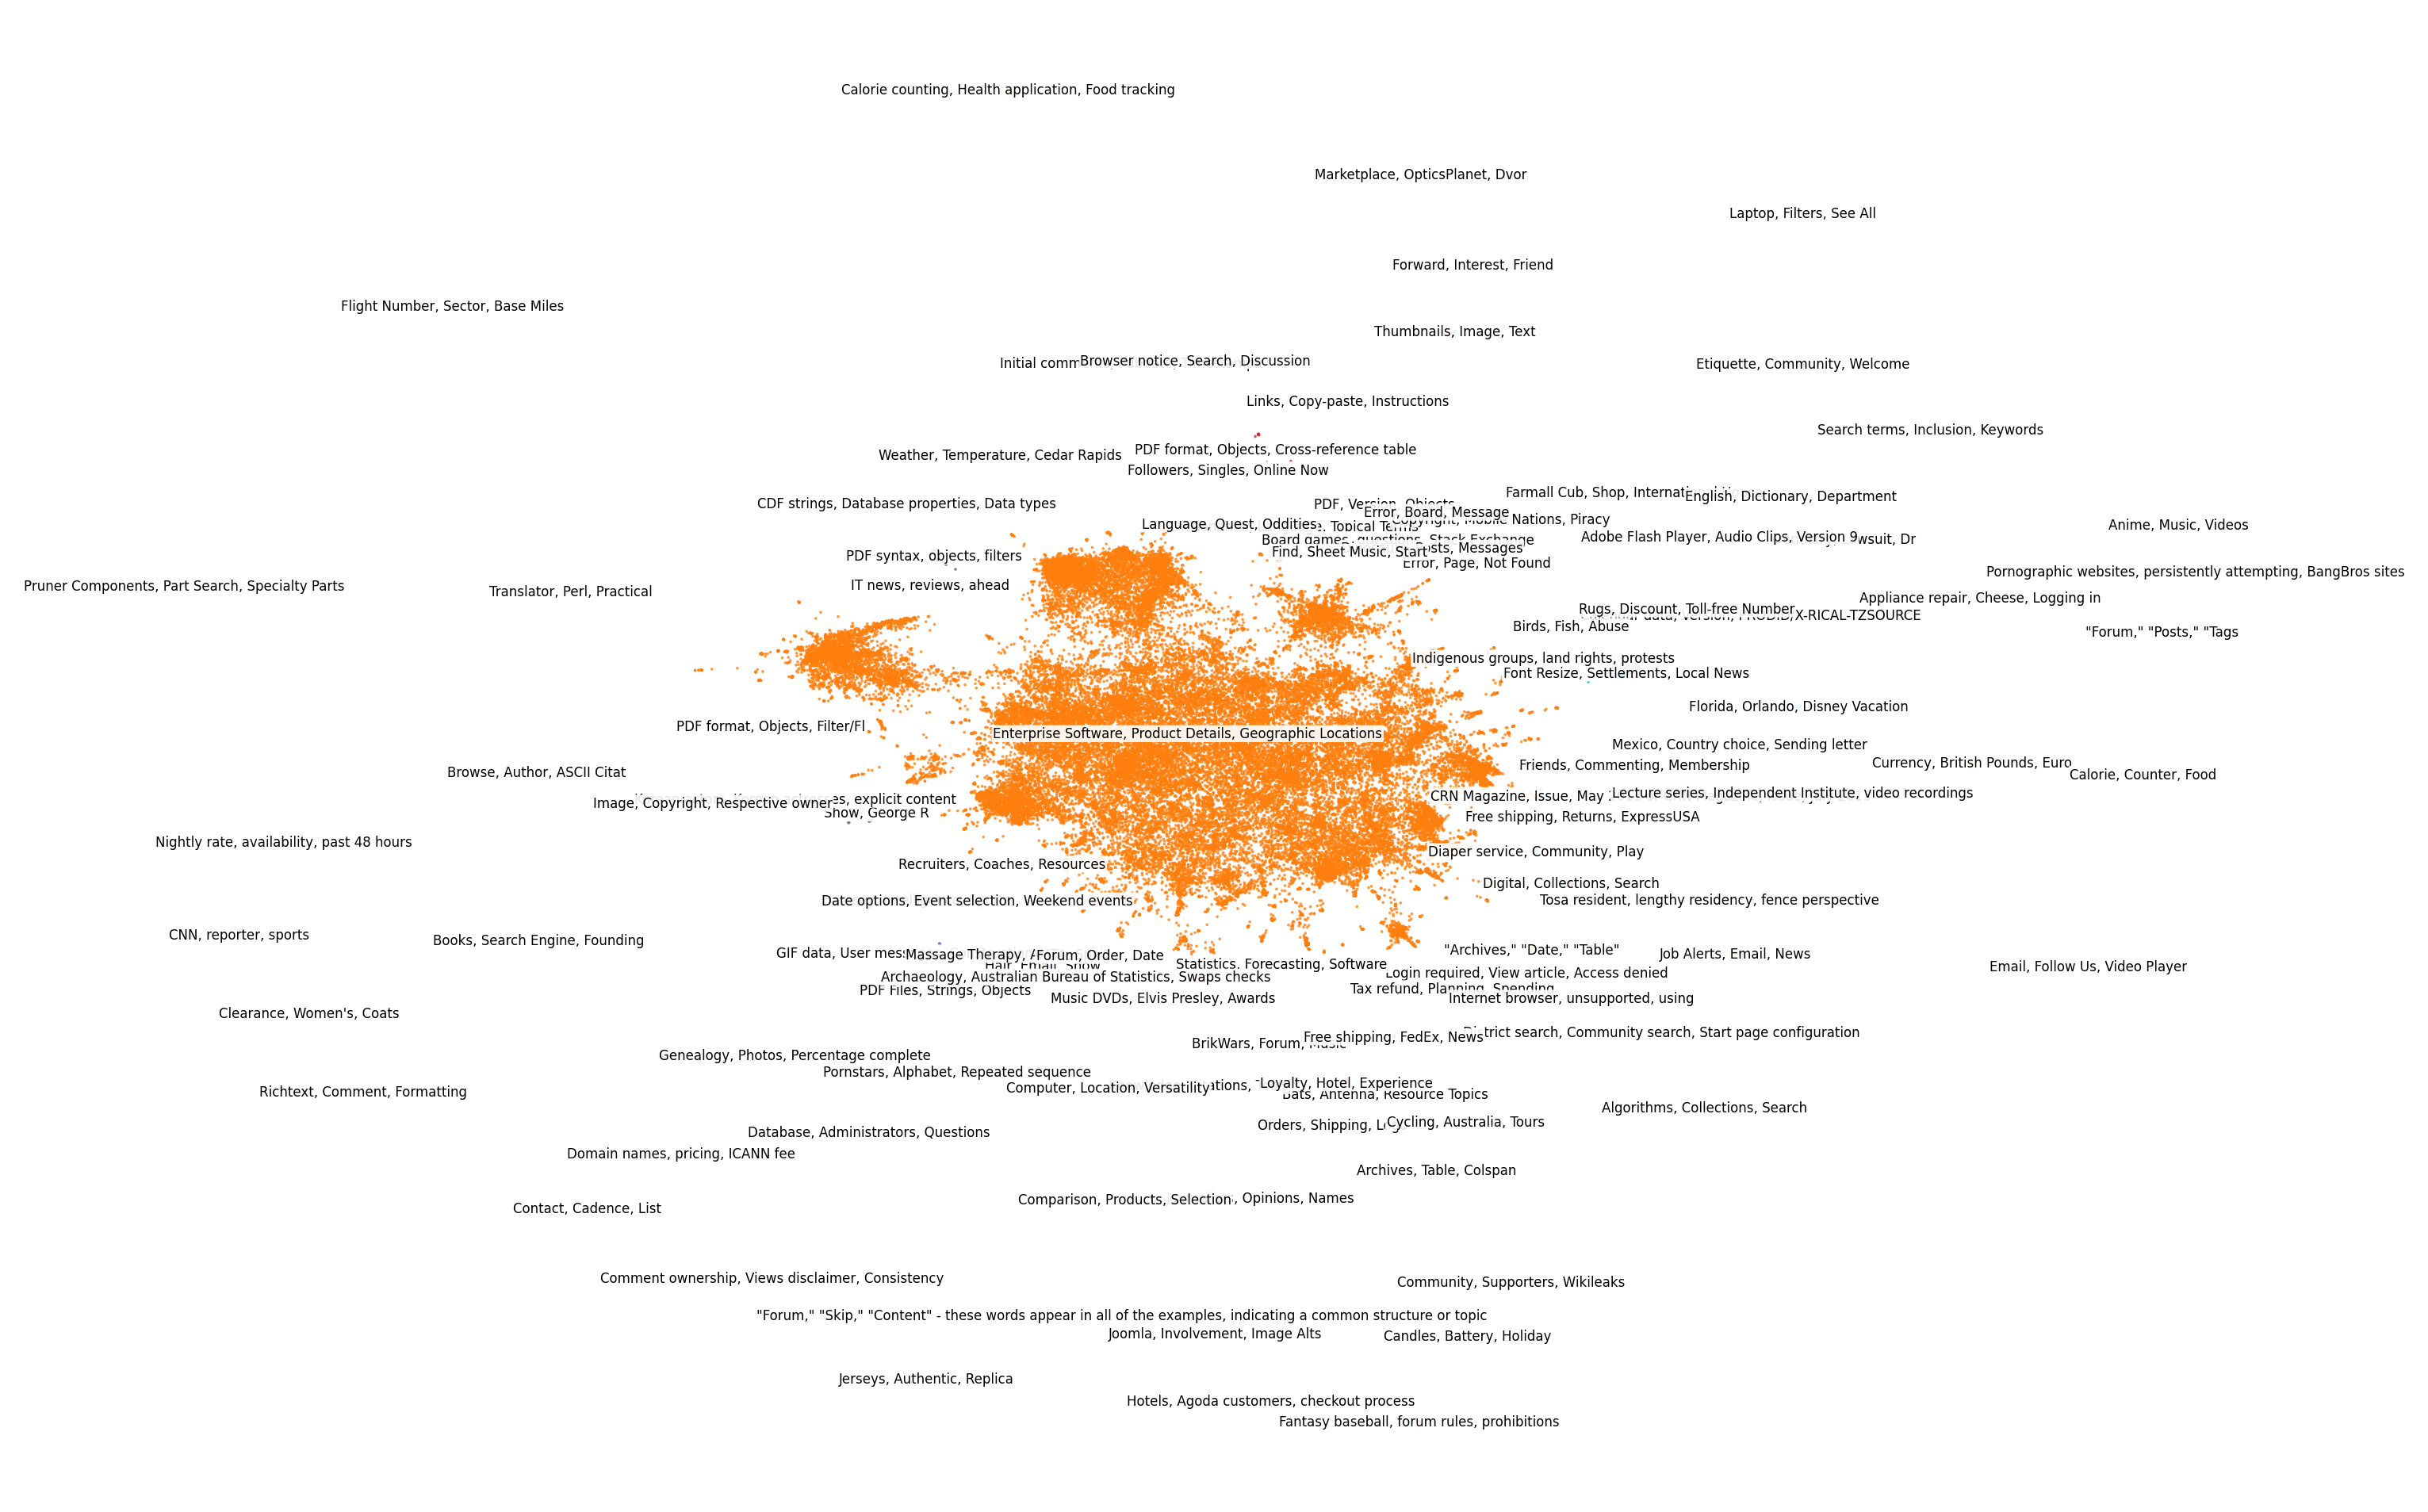

In [1]:
import pandas as pd
from src.text_clustering import ClusterClassifier
from cycler import cycler
import matplotlib.pyplot as plt

# Ensure you have a pandas DataFrame named pandas_df
# Example:
# pandas_df = pd.DataFrame({'content': ["text1", "text2", "text3"]})

# Create an instance of ClusterClassifier
cc = ClusterClassifier(
    embed_device="cuda",
)
cc.load("./content_clusters")
# cc.optimize_parameters()

cc.show()

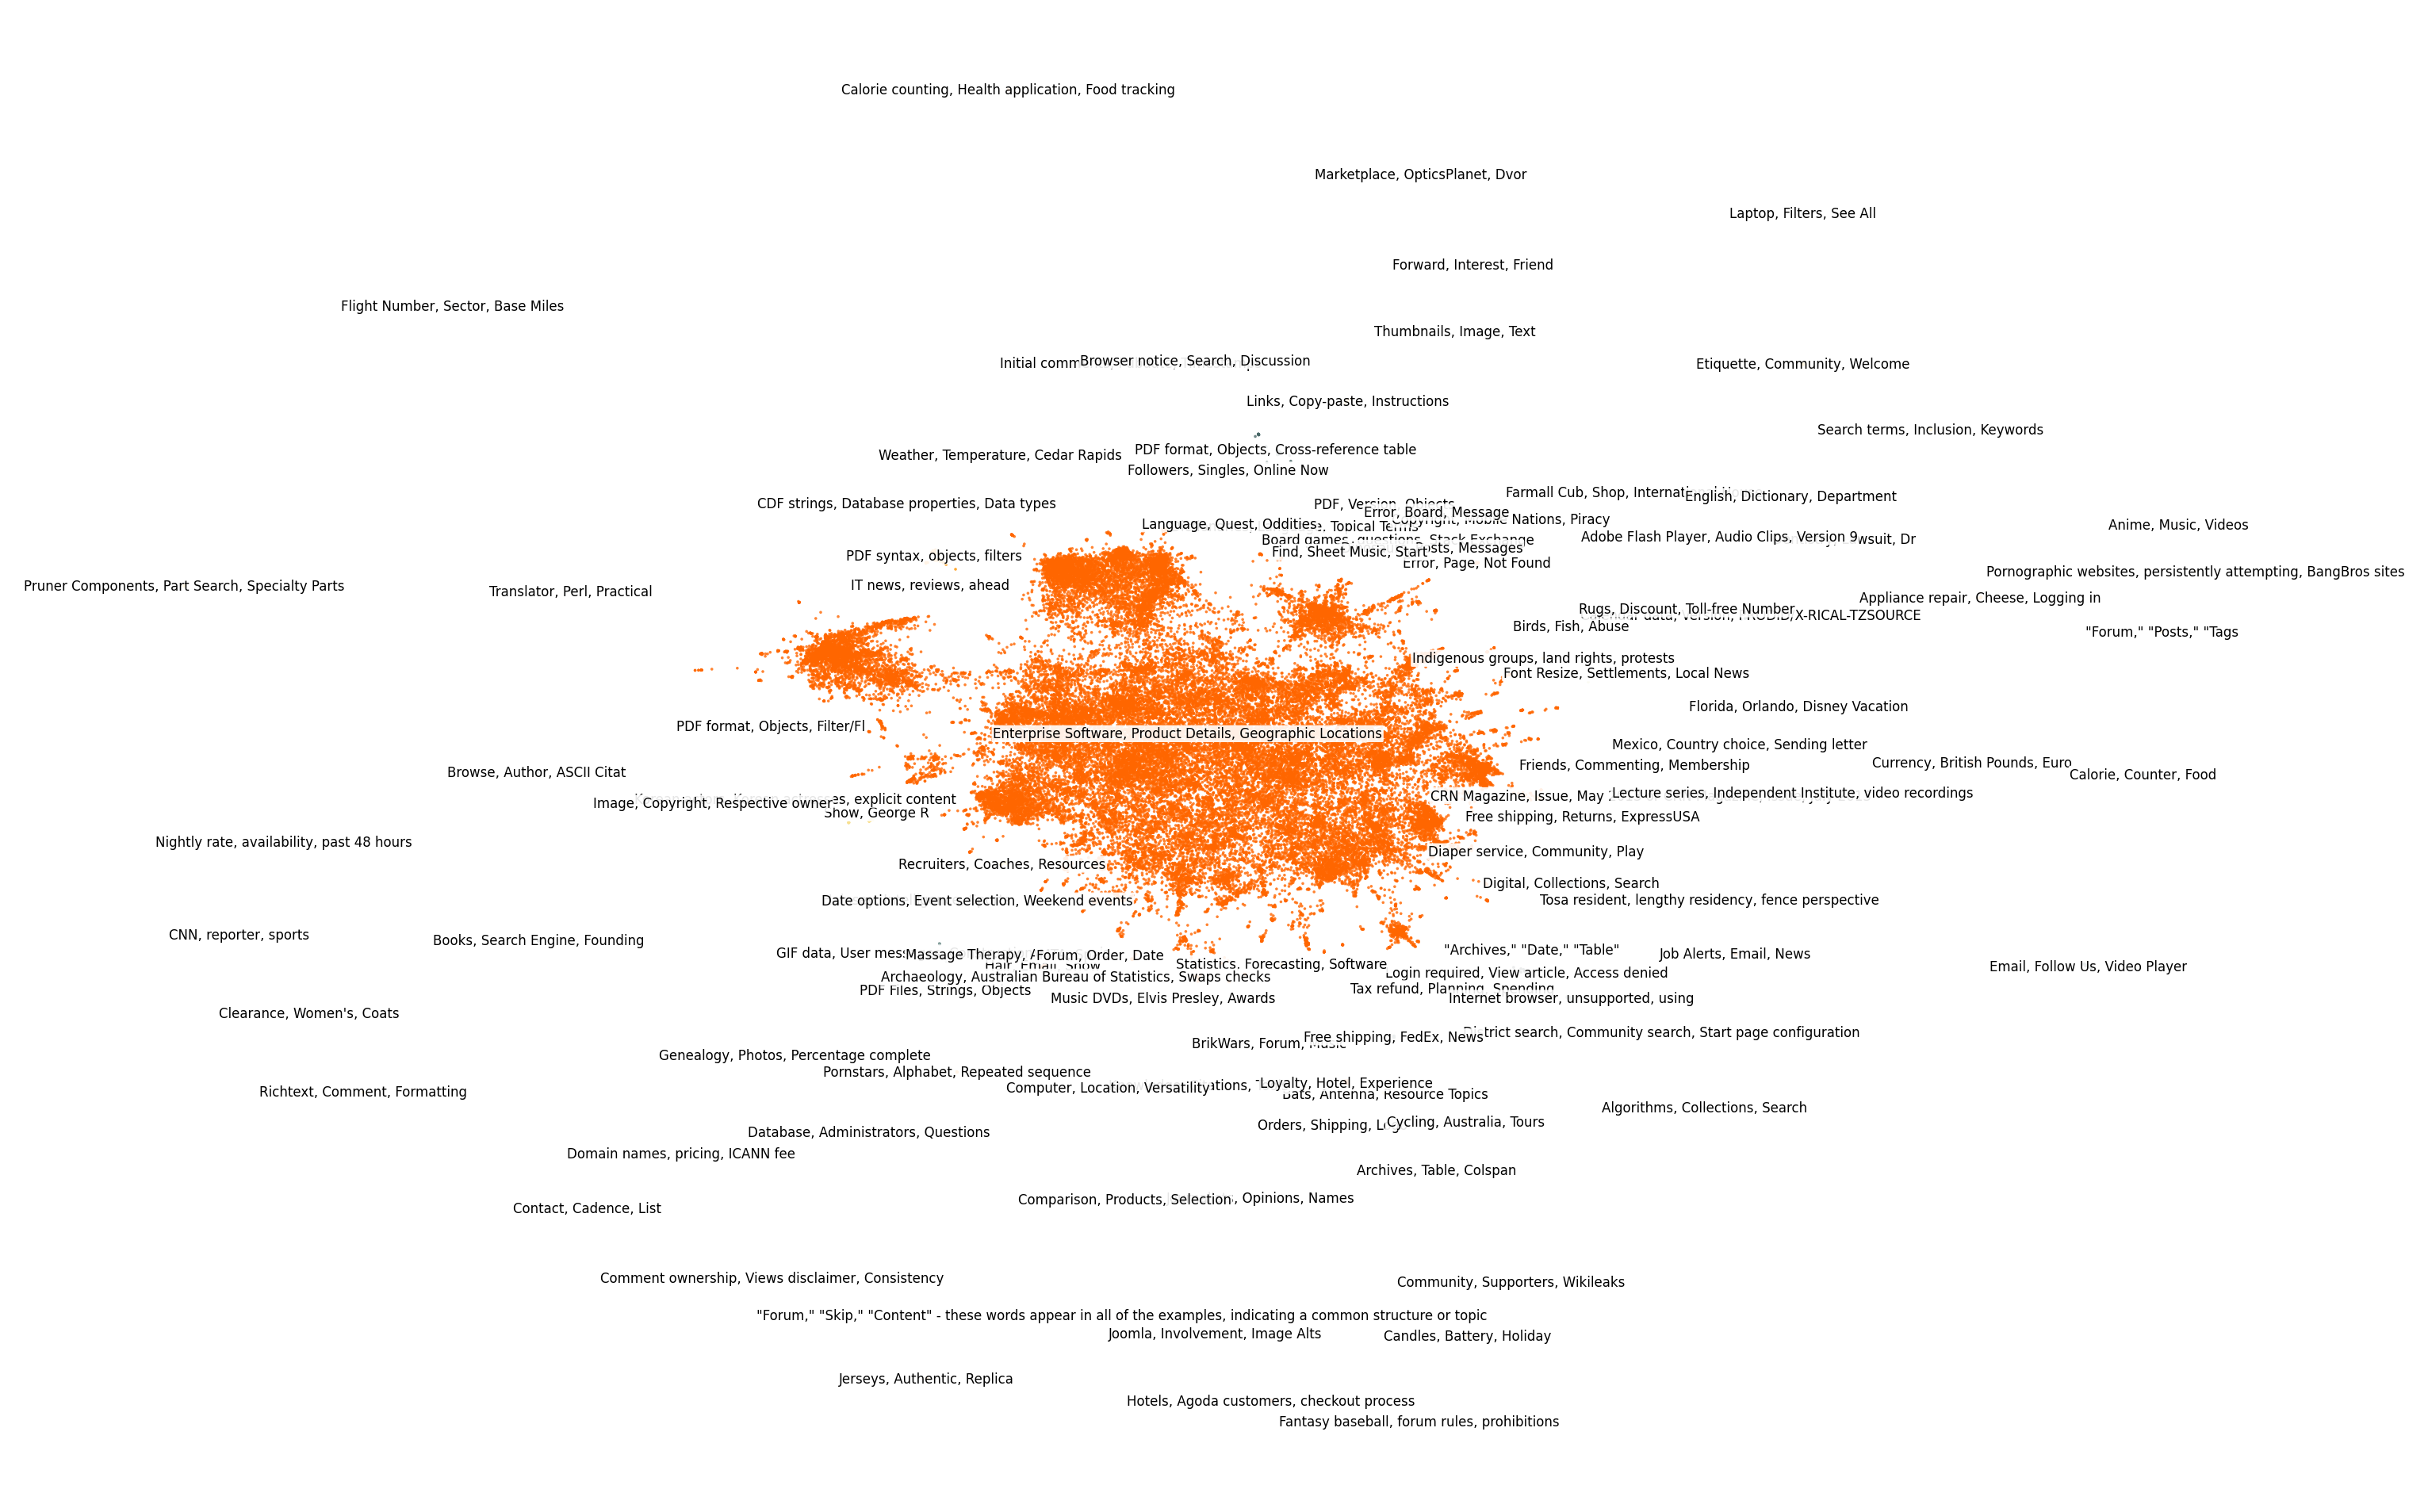

In [3]:
from cycler import cycler
import matplotlib.pyplot as plt

default_cycler = (cycler(color=[
    "#0F0A0A",
    "#FF6600",
    "#FFBE00",
    "#496767",
    "#87A19E",
    "#FF9200",
    "#0F3538",
    "#F8E08E",
    "#0F2021",
    "#FAFAF0"])
    )
plt.rc('axes', prop_cycle=default_cycler)
cc.show()

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
import numpy as np
from matplotlib.patches import Rectangle

def visualize_cluster_proportions(labels, summaries):
    # Count the number of items in each cluster
    cluster_counts = Counter(labels)
    
    # Sort the clusters by their labels, excluding -1 (which is typically used for noise)
    sorted_clusters = sorted([item for item in cluster_counts.items() if item[0] != -1])
    
    # Separate the labels and counts
    cluster_labels, counts = zip(*sorted_clusters)
    
    # Calculate the proportion of noise points (label -1)
    noise_count = cluster_counts.get(-1, 0)
    total_count = sum(counts) + noise_count
    noise_proportion = noise_count / total_count if total_count > 0 else 0
    
    # Calculate percentages
    percentages = [count / sum(counts) * 100 for count in counts]
    
    # Create a color palette
    colors = sns.color_palette("husl", len(cluster_labels))
    
    # Create a figure with two subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10), gridspec_kw={'width_ratios': [1, 1]})
    
    # Create a pie chart on the left subplot
    wedges, texts, autotexts = ax1.pie(counts, autopct='%1.1f%%', startangle=90, colors=colors,
                                       textprops=dict(color="w", weight="bold", size=10))
    
    # Add title to the pie chart
    ax1.set_title('Proportion of Data Points in Each Cluster', fontsize=16)
    
    # Add a note about noise proportion
    ax1.annotate(f'Noise: {noise_proportion:.1%}', xy=(0.95, 0.05), xycoords='axes fraction',
                 horizontalalignment='right', verticalalignment='bottom', fontsize=10)
    
    # Ensure the pie chart is circular
    ax1.axis('equal')
    
    # Create colored text with percentages for each cluster on the right subplot
    ax2.set_ylim(0, 1)
    ax2.set_xlim(0, 1)
    ax2.axis('off')  # Turn off axes for the text subplot
    
    for i, (label, summary, color, percentage) in enumerate(zip(cluster_labels, summaries.values(), colors, percentages)):
        y_position = 1 - (i + 1) / (len(cluster_labels) + 1)
        rect = Rectangle((0, y_position), 0.03, 0.03, facecolor=color, edgecolor='none')
        ax2.add_patch(rect)
        ax2.text(0.05, y_position, f'Cluster {label} ({percentage:.1f}%): {summary}', 
                 va='center', ha='left', wrap=True, fontsize=12)
    
    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()
    # labels = cc.cluster_labels
# summaries = cc.cluster_summaries

labels = cc.cluster_labels
summaries = cc.cluster_summaries
visualize_cluster_proportions(labels, summaries)

In [3]:
cc.print_cluster_examples(0, num_examples=50, max_chars=20000)

Cluster 0 examples:
Cluster summary: Enterprise Software, Product Details, Geographic Locations
Number of documents in cluster: 47966

Random examples:

Example 1:
Text length: 50 characters
Full text:
CJM052 - Black End Table
[[table]]
[[tr]]
[[th]]
s

Example 2:
Text length: 50 characters
Full text:
Find the best mobile broadband contract for you
Co

Example 3:
Text length: 50 characters
Full text:
Bedesem Hoping Lady Luck Is More Gracious
July 28,

Example 4:
Text length: 50 characters
Full text:
Galge
Fra Wikipedia, den frie encyklopedi
Gå til:n

Example 5:
Text length: 50 characters
Full text:
Full rise telescopic piston vehicle lift
by David 

Example 6:
Text length: 50 characters
Full text:
Cent. Michigan 62, Ark.-Pine Bluff 45
Dec. 23, 201

Example 7:
Text length: 50 characters
Full text:
Featured
[[img]][[attr]]alt="article image"!!attr!

Example 8:
Text length: 50 characters
Full text:
Crimmins receives Kibbie award
Mark Crimmins has r

Example 9:
Text length: 50 characters
F

In [6]:
cc.texts

['! 07/24/2000 mhamer /tmp/l-1-81-nc.onoff.bathnav! ',
 '! 07/24/2000 mhamer /tmp/l-4-79-sc.onoff.bathgravn',
 '! 07/24/2000 mhamer /tmp/l-7-77-wg.onoff.multichan',
 '! Zum Reiherhorst 32, Stelle Jenny\nAhoi,\nwollte no',
 '! thread theory ♥\n« previous entry | next entry »\n',
 "!!!!!!.....CONTRO LA PRIVATIZZAZIONE DELL'ACQUA IN",
 '!!!**Profiler/Lenses/Some Flex Parts/Pants/Jersey/',
 '!!!Amazon liefert zur Zeit auch das i9100G statt i',
 '!!!Go Party Club!!!\nLady Gaga\nDescripción: Tercera',
 '!!\nWelcome to Save Point!\nFormerly known as RMVXP,',
 '!@48��d�����!⋽��N��/}�SX��dYm�1s����#�����/���REQ�',
 '!\nImportant Hotel Information\nWynn Las Vegas charg',
 '!debian-binary 1219781901 0 0 100644 4 `2.0control',
 '!debian-binary 1264851468 0 0 100644 4 `2.0control',
 '!debian-binary 1285550846 0 0 100644 4 `2.0control',
 '!debian-binary 1295283451 0 0 100644 4 `2.0control',
 '!debian-binary 1297493667 0 0 100644 4 `2.0control',
 '!debian-binary 1314905862 0 0 100644 4 `2.0control',


In [ ]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def visualize_tsne(embeddings, labels, summaries, perplexity=30, n_iter=1000):
    # Perform t-SNE
    tsne = TSNE(n_components=2, perplexity=perplexity, n_iter=n_iter, random_state=42)
    tsne_results = tsne.fit_transform(embeddings)

    # Create a DataFrame for easier plotting
    df = pd.DataFrame({
        'X': tsne_results[:, 0],
        'Y': tsne_results[:, 1],
        'labels': labels
    })

    # Set up the plot
    fig, ax = plt.subplots(figsize=(12, 8), dpi=300)
    
    # Create a color map (matching show_mpl style)
    unique_labels = np.unique(labels)
    color_map = {-1: 'C0'}  # 噪声点用 'C0'
    for i, label in enumerate(unique_labels):
        if label != -1:
            color_map[label] = f'C{(i % 9) + 1}'

    # Plot each point
    scatter = ax.scatter(
        df['X'],
        df['Y'],
        c=[color_map[label] for label in df['labels']],
        s=0.75,
        alpha=0.8,
        linewidths=0
    )

    # Add cluster summaries as annotations
    for label, summary in summaries.items():
        if label != -1:  # Exclude noise points
            cluster_points = df[df['labels'] == label]
            centroid_x = cluster_points['X'].mean()
            centroid_y = cluster_points['Y'].mean()
            t = ax.text(
                centroid_x,
                centroid_y,
                summary,
                horizontalalignment='center',
                verticalalignment='center',
                fontsize=4,
            )
            t.set_bbox(dict(facecolor='white', alpha=0.9, edgecolor='none', boxstyle='round,pad=0.1'))

    ax.set_axis_off()
    plt.tight_layout()
    plt.show()

    return fig, ax

# Use the function
fig, ax = visualize_tsne(cc.embeddings, cc.cluster_labels, cc.cluster_summaries)

In [ ]:
import numpy as np
noise_ratio = np.sum(cc.cluster_labels == 0) / len(cc.cluster_labels)
noise_ratio
cc.cluster_summaries

In [ ]:
from sklearn.metrics import silhouette_score
import numpy as np

def optimize_parameters(cc, eps_range=(0.1, 2.0), min_samples_range=(2, 20), n_trials=20):
    best_score = -1
    best_params = None
    
    for _ in range(n_trials):
        eps = np.random.uniform(*eps_range)
        min_samples = np.random.randint(*min_samples_range)
        
        cc.dbscan_eps = eps
        cc.dbscan_min_samples = min_samples
        cc.cluster_labels = cc.cluster(cc.projections)
        
        # 跳过全是噪声的情况
        if len(set(cc.cluster_labels)) == 1:
            continue
        
        score = silhouette_score(cc.projections, cc.cluster_labels)
        
        if score > best_score:
            best_score = score
            best_params = (eps, min_samples)
    
    return best_params

best_eps, best_min_samples = optimize_parameters(cc)
print(f"Best parameters: eps={best_eps:.2f}, min_samples={best_min_samples}")

cc.dbscan_eps = best_eps
cc.dbscan_min_samples = best_min_samples
cc.cluster_labels = cc.cluster(cc.projections)
cc.show()

In [ ]:
import numpy as np
from umap import UMAP
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from itertools import product

def optimize_umap_parameters(embeddings, labels, n_neighbors_range=(5, 50), min_dist_range=(0.0, 0.9), n_components=2):
    best_score = -np.inf
    best_params = None
    best_projection = None
    
    n_neighbors_values = np.linspace(n_neighbors_range[0], n_neighbors_range[1], 10, dtype=int)
    min_dist_values = np.linspace(min_dist_range[0], min_dist_range[1], 10)
    
    for n_neighbors, min_dist in product(n_neighbors_values, min_dist_values):
        umap = UMAP(n_neighbors=n_neighbors, min_dist=min_dist, n_components=n_components, random_state=42)
        projection = umap.fit_transform(embeddings)
        
        # Compute clustering quality scores
        sil_score = silhouette_score(projection, labels)
        ch_score = calinski_harabasz_score(projection, labels)
        
        # Combine scores (you might want to adjust the weights)
        combined_score = sil_score + ch_score / 1000
        
        if combined_score > best_score:
            best_score = combined_score
            best_params = {'n_neighbors': n_neighbors, 'min_dist': min_dist}
            best_projection = projection
    
    return best_params, best_projection

def visualize_umap_dbscan(projection, labels, summaries):
    df = pd.DataFrame({
        'X': projection[:, 0],
        'Y': projection[:, 1],
        'labels': labels
    })

    fig, ax = plt.subplots(figsize=(12, 8), dpi=300)
    
    unique_labels = np.unique(labels)
    color_map = {-1: 'C0'}
    for i, label in enumerate(unique_labels):
        if label != -1:
            color_map[label] = f'C{(i % 9) + 1}'

    scatter = ax.scatter(
        df['X'],
        df['Y'],
        c=[color_map[label] for label in df['labels']],
        s=0.75,
        alpha=0.8,
        linewidths=0
    )

    for label, summary in summaries.items():
        if label != -1:
            cluster_points = df[df['labels'] == label]
            centroid_x = cluster_points['X'].mean()
            centroid_y = cluster_points['Y'].mean()
            t = ax.text(
                centroid_x,
                centroid_y,
                summary,
                horizontalalignment='center',
                verticalalignment='center',
                fontsize=4,
            )
            t.set_bbox(dict(facecolor='white', alpha=0.9, edgecolor='none', boxstyle='round,pad=0.1'))

    ax.set_axis_off()
    plt.tight_layout()
    plt.show()

    return fig, ax

# Use the functions
best_params, best_projection = optimize_umap_parameters(cc.embeddings, cc.cluster_labels)
print(f"Best UMAP parameters: {best_params}")

fig, ax = visualize_umap_dbscan(best_projection, cc.cluster_labels, cc.cluster_summaries)

In [ ]:

noise_ratio = cc.calculate_noise_ratio()
noise_ratio